In [1]:
from pynq import Overlay, allocate, os
import numpy as np
import time

print(os.getcwd())
print(os.listdir())

ol = Overlay("sa_engine.bit")
print("IP blocks:", list(ol.ip_dict.keys()))

ip = ol.sa_engine_ip_0
rm = ip.register_map
print(ip.register_map)

/home/xilinx/jupyter_notebooks/cau_systolic
['sa_engine.bit', 'matrix_A_B.hex', 'CAU_Capstone_v2.ipynb', 'CAU_Capstone_v1.ipynb', 'sa_engine(core fixed ver)', 'sa_engine(251109)', 'sa_engine(251108)', 'CAU_Capstone.ipynb', 'loaded.xclbin', '.ipynb_checkpoints', 'sa_engine.hwh']


IP blocks: ['sa_engine_ip_0', 'processing_system7_0']
RegisterMap {
  CTRL_STATUS = Register(value=0),
  READ_BASE = Register(value=0),
  WRITE_BASE = Register(value=0)
}


# DDR Setting

In [2]:
INPUT_buf = allocate(shape=(16, 8), dtype=np.int8, cacheable=False)
OUTPUT_buf = allocate(shape=(8, 8), dtype=np.int32, cacheable=False)

R_BASE = INPUT_buf.physical_address
W_BASE = OUTPUT_buf.physical_address

INPUT_buf[:] = np.random.randint(-128, 127, size=(16,8), dtype=np.int8)
OUTPUT_buf[:] = 0

INPUT_buf.flush()
OUTPUT_buf.flush()

# Testbench

## HW Function

In [3]:
# Status bit mask
START_MASK = 0b0001  # bit[0]
DONE_MASK  = 0b0010  # bit[1]
BUSY_MASK  = 0b0100  # bit[2]
ERR_MASK   = 0b1000  # bit[3]

def ip_get_status(ip):
    return int(rm.CTRL_STATUS)

def ip_is_done(status):
    return bool(status & DONE_MASK)

def ip_is_busy(status):
    return bool(status & BUSY_MASK)

def ip_has_error(status):
    return bool(status & ERR_MASK)

def ip_wait_done(ip, timeout_sec=1.0, poll_interval=0.001):
    t0 = time.time()
    while True:
        status = ip_get_status(ip)

        if ip_has_error(status):
            raise RuntimeError(f"IP ERROR, status=0b{status:04b}")

        if ip_is_done(status) and not ip_is_busy(status):
            break

        if time.time() - t0 > timeout_sec:
            raise TimeoutError(f"IP DONE timeout, last status=0b{status:04b}")

        time.sleep(poll_interval)

def call_fpga(ip, R_BASE, W_BASE):

    status = ip_get_status(ip)
    rm.CTRL_STATUS = 0
    rm.READ_BASE  = R_BASE
    rm.WRITE_BASE = W_BASE
    rm.CTRL_STATUS = START_MASK
    rm.CTRL_STATUS = (status & ~START_MASK)
    rm.CTRL_STATUS = 0

    ip_wait_done(ip, timeout_sec=20.0)
    
    OUTPUT_buf.invalidate()

    print("ip done")

## HW Compute

In [4]:
start_data_in = time.perf_counter()
INPUT_buf.flush()
end_data_in = time.perf_counter()

start_fpga = time.perf_counter()
call_fpga(ip, R_BASE, W_BASE)
end_fpga = time.perf_counter()

start_data_out = time.perf_counter()
OUTPUT_buf.invalidate()
result_fpga = OUTPUT_buf[:, :].copy()
end_data_out = time.perf_counter()

ip done


## SW Reference

In [ ]:
#########################################
# Input Data Split
#########################################
A_buf = INPUT_buf[:8, :]
B_buf = INPUT_buf[8:, :]

#########################################
# NumPy CPU Reference
#########################################
start_cpu_numpy = time.perf_counter()
ref_numpy = np.matmul(
    A_buf.astype(np.int32),
    B_buf.astype(np.int32)
)
end_cpu_numpy = time.perf_counter()
print(ref_numpy)

#########################################
# PyTorch : pynq-z2 내부적으로 pytorch X 
#########################################

[[ -6144 -13658  -7661  -5894  -8735  -4078   1187 -18438]
 [  -293   9895  17942  12505 -10699  -4693  -4160   6558]
 [ 17292  -9454 -15451 -24617  20712   8938  13233  -6793]
 [ 30393   8176   7925  14071  -3542 -22089 -11306  13497]
 [ -5599   3071    982 -14502 -25054   9975   5154 -15369]
 [-23679 -10236 -11623   7388  22727 -32785  14637 -13127]
 [  8648  11374   9326  -4862  16904 -27309  20795  -4100]
 [-19551  16124 -10659   9821   5076 -28298   6448   3856]]


## HW vs SW

In [ ]:
# ============================
# Step 5: ACCURACY CHECK
# ============================
diff_numpy = np.abs(ref_numpy - result_fpga)
max_err_numpy = np.max(diff_numpy)

# ============================
# Step 6: PERFORMANCE METRICS
# ============================
total_ops = 64

acc_latency = end_fpga - start_fpga
total_hw_time = end_data_out - start_data_in
hw_end_to_end = (total_ops / total_hw_time) / 1e9

sw_time_numpy = end_cpu_numpy - start_cpu_numpy
speedup_latency_numpy = sw_time_numpy / acc_latency
speedup_total_numpy = sw_time_numpy / total_hw_time

print(result_fpga)
print(ref_numpy)

[[ -6144 -13658  -7661  -5894  -8735  -4078   1187 -18438]
 [  -293   9895  17942  12505 -10699  -4693  -4160   6558]
 [ 17292  -9454 -15451 -24617  20712   8938  13233  -6793]
 [ 30393   8176   7925  14071  -3542 -22089 -11306  13497]
 [ -5599   3071    982 -14502 -25054   9975   5154 -15369]
 [-23679 -10236 -11623   7388  22727 -32785  14637 -13127]
 [  8648  11374   9326  -4862  16904 -27309  20795  -4100]
 [-19551  16124 -10659   9821   5076 -28298   6448   3856]]
[[ -6144 -13658  -7661  -5894  -8735  -4078   1187 -18438]
 [  -293   9895  17942  12505 -10699  -4693  -4160   6558]
 [ 17292  -9454 -15451 -24617  20712   8938  13233  -6793]
 [ 30393   8176   7925  14071  -3542 -22089 -11306  13497]
 [ -5599   3071    982 -14502 -25054   9975   5154 -15369]
 [-23679 -10236 -11623   7388  22727 -32785  14637 -13127]
 [  8648  11374   9326  -4862  16904 -27309  20795  -4100]
 [-19551  16124 -10659   9821   5076 -28298   6448   3856]]



## **Performance Comparison: FPGA vs NumPy**

### **Matrix Multiplication Details**
- **Accuracy Check**:
  - ✅ **Max Difference (NumPy vs FPGA)**: `0`

---

### **Latency**
| Framework  | Latency (sec) |
|------------|--------------|
| NumPy   | `0.001632`  |
| FPGA    | `0.002195`  |

---

### **Speedup Comparison**
| Comparison  | Speedup (Latency) | Speedup (Total) |
|-------------|------------------|-----------------|
| FPGA vs NumPy   | `0.74×` | `0.24×` |

✅ **Test Completed!**


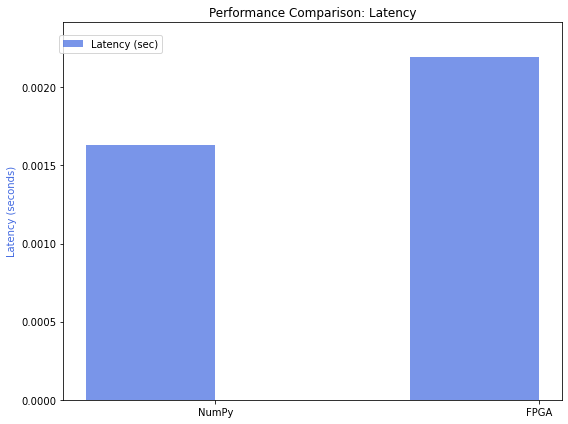

In [7]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# Generate Markdown dynamically
md_text = f"""
## **Performance Comparison: FPGA vs NumPy**

### **Matrix Multiplication Details**
- **Accuracy Check**:
  - {"✅" if max_err_numpy == 0 else "❌"} **Max Difference (NumPy vs FPGA)**: `{max_err_numpy}`

---

### **Latency**
| Framework  | Latency (sec) |
|------------|--------------|
| NumPy   | `{sw_time_numpy:.6f}`  |
| FPGA    | `{acc_latency:.6f}`  |

---

### **Speedup Comparison**
| Comparison  | Speedup (Latency) | Speedup (Total) |
|-------------|------------------|-----------------|
| FPGA vs NumPy   | `{speedup_latency_numpy:.2f}×` | `{speedup_total_numpy:.2f}×` |

✅ **Test Completed!**
"""

# Display the Markdown
display(Markdown(md_text))

# ================================
# Visualization
# ================================

# Data for plotting
frameworks = ["NumPy", "FPGA"]
latencies = [sw_time_numpy, acc_latency]  # Lower is better

x = np.arange(len(frameworks))

# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Bar width
bar_width = 0.4

# Plot latency
ax1.bar(x - bar_width / 2, latencies, width=bar_width, label="Latency (sec)", color='royalblue', alpha=0.7)
ax1.set_ylabel("Latency (seconds)", color='royalblue')
ax1.set_yscale("linear")
ax1.set_ylim(0, max(latencies) * 1.1)

ax1.set_xticks(x)
ax1.set_xticklabels(frameworks)
ax1.set_title("Performance Comparison: Latency")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))

# Adjust layout and show plot
plt.tight_layout()
plt.show()